In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [112]:
#torch.manual_seed(7)

In [113]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62384/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62384/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [114]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62384/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62384/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [115]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [116]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

l2_lambda = 0.00001

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 

        l2_penalty = sum(torch.sum(p**2) for p in model.parameters())
        loss += l2_lambda * l2_penalty 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 189.58it/s]


Epoch 0/100, Loss: 0.015216702595353127, train dataset accuracy: 86.85166666666667
test dataset accuracy: 95.41%


100%|██████████| 235/235 [00:01<00:00, 216.63it/s]


Epoch 1/100, Loss: 0.011787810362875462, train dataset accuracy: 95.68333333333334
test dataset accuracy: 95.81%


100%|██████████| 235/235 [00:01<00:00, 181.52it/s]


Epoch 2/100, Loss: 0.010929306969046593, train dataset accuracy: 96.13
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:01<00:00, 179.40it/s]


Epoch 3/100, Loss: 0.011178377084434032, train dataset accuracy: 96.27333333333333
test dataset accuracy: 96.2%


100%|██████████| 235/235 [00:01<00:00, 184.40it/s]


Epoch 4/100, Loss: 0.006683750078082085, train dataset accuracy: 96.41333333333333
test dataset accuracy: 96.42%


100%|██████████| 235/235 [00:01<00:00, 176.03it/s]


Epoch 5/100, Loss: 0.011870291084051132, train dataset accuracy: 96.43666666666667
test dataset accuracy: 96.1%


100%|██████████| 235/235 [00:01<00:00, 171.92it/s]


Epoch 6/100, Loss: 0.00772393774241209, train dataset accuracy: 96.50833333333334
test dataset accuracy: 96.39%


100%|██████████| 235/235 [00:01<00:00, 181.07it/s]


Epoch 7/100, Loss: 0.010813294909894466, train dataset accuracy: 96.57166666666667
test dataset accuracy: 96.28%


100%|██████████| 235/235 [00:01<00:00, 167.98it/s]


Epoch 8/100, Loss: 0.00868566706776619, train dataset accuracy: 96.63166666666666
test dataset accuracy: 96.24%


100%|██████████| 235/235 [00:01<00:00, 175.72it/s]


Epoch 9/100, Loss: 0.009699899703264236, train dataset accuracy: 96.605
test dataset accuracy: 95.95%


100%|██████████| 235/235 [00:01<00:00, 173.24it/s]


Epoch 10/100, Loss: 0.00887313298881054, train dataset accuracy: 96.66
test dataset accuracy: 96.57%


100%|██████████| 235/235 [00:01<00:00, 183.40it/s]


Epoch 11/100, Loss: 0.01189199648797512, train dataset accuracy: 96.66333333333333
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 187.66it/s]


Epoch 12/100, Loss: 0.007763570174574852, train dataset accuracy: 96.67666666666666
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 182.33it/s]


Epoch 13/100, Loss: 0.013007404282689095, train dataset accuracy: 96.65833333333333
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 176.28it/s]


Epoch 14/100, Loss: 0.010558642446994781, train dataset accuracy: 96.69166666666666
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 171.59it/s]


Epoch 15/100, Loss: 0.010240079835057259, train dataset accuracy: 96.71333333333334
test dataset accuracy: 96.47%


100%|██████████| 235/235 [00:01<00:00, 194.24it/s]


Epoch 16/100, Loss: 0.008696780540049076, train dataset accuracy: 96.765
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:01<00:00, 176.16it/s]


Epoch 17/100, Loss: 0.008370096795260906, train dataset accuracy: 96.77166666666666
test dataset accuracy: 96.71%


100%|██████████| 235/235 [00:01<00:00, 180.15it/s]


Epoch 18/100, Loss: 0.012512663379311562, train dataset accuracy: 96.79833333333333
test dataset accuracy: 96.28%


100%|██████████| 235/235 [00:01<00:00, 181.08it/s]


Epoch 19/100, Loss: 0.0093879085034132, train dataset accuracy: 96.72
test dataset accuracy: 96.18%


100%|██████████| 235/235 [00:01<00:00, 173.84it/s]


Epoch 20/100, Loss: 0.011882415041327477, train dataset accuracy: 96.72166666666666
test dataset accuracy: 96.81%


100%|██████████| 235/235 [00:01<00:00, 169.72it/s]


Epoch 21/100, Loss: 0.01193293184041977, train dataset accuracy: 96.75166666666667
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:01<00:00, 179.86it/s]


Epoch 22/100, Loss: 0.005989041645079851, train dataset accuracy: 96.8
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 170.21it/s]


Epoch 23/100, Loss: 0.012301883660256863, train dataset accuracy: 96.65166666666667
test dataset accuracy: 96.06%


100%|██████████| 235/235 [00:01<00:00, 179.91it/s]


Epoch 24/100, Loss: 0.01213395968079567, train dataset accuracy: 96.64333333333333
test dataset accuracy: 96.22%


100%|██████████| 235/235 [00:01<00:00, 176.40it/s]


Epoch 25/100, Loss: 0.014816785231232643, train dataset accuracy: 96.66666666666667
test dataset accuracy: 96.38%


100%|██████████| 235/235 [00:01<00:00, 173.80it/s]


Epoch 26/100, Loss: 0.007433664053678513, train dataset accuracy: 96.71833333333333
test dataset accuracy: 96.76%


100%|██████████| 235/235 [00:01<00:00, 175.49it/s]


Epoch 27/100, Loss: 0.00775632681325078, train dataset accuracy: 96.67
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:01<00:00, 189.79it/s]


Epoch 28/100, Loss: 0.008591904304921627, train dataset accuracy: 96.72333333333333
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:01<00:00, 174.53it/s]


Epoch 29/100, Loss: 0.013025480322539806, train dataset accuracy: 96.71833333333333
test dataset accuracy: 96.22%


100%|██████████| 235/235 [00:01<00:00, 178.12it/s]


Epoch 30/100, Loss: 0.01089862734079361, train dataset accuracy: 96.74833333333333
test dataset accuracy: 96.57%


100%|██████████| 235/235 [00:01<00:00, 181.85it/s]


Epoch 31/100, Loss: 0.009076179936528206, train dataset accuracy: 96.62333333333333
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 186.23it/s]


Epoch 32/100, Loss: 0.014297861605882645, train dataset accuracy: 96.70333333333333
test dataset accuracy: 96.12%


100%|██████████| 235/235 [00:01<00:00, 177.34it/s]


Epoch 33/100, Loss: 0.010546303354203701, train dataset accuracy: 96.67333333333333
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:01<00:00, 187.06it/s]


Epoch 34/100, Loss: 0.010052157565951347, train dataset accuracy: 96.64
test dataset accuracy: 96.64%


100%|██████████| 235/235 [00:01<00:00, 182.30it/s]


Epoch 35/100, Loss: 0.010202711448073387, train dataset accuracy: 96.71333333333334
test dataset accuracy: 96.55%


100%|██████████| 235/235 [00:01<00:00, 179.87it/s]


Epoch 36/100, Loss: 0.010434279218316078, train dataset accuracy: 96.85666666666667
test dataset accuracy: 95.76%


100%|██████████| 235/235 [00:01<00:00, 167.15it/s]


Epoch 37/100, Loss: 0.013664856553077698, train dataset accuracy: 96.43666666666667
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:01<00:00, 176.88it/s]


Epoch 38/100, Loss: 0.00989329069852829, train dataset accuracy: 96.76333333333334
test dataset accuracy: 96.64%


100%|██████████| 235/235 [00:01<00:00, 184.53it/s]


Epoch 39/100, Loss: 0.01201623398810625, train dataset accuracy: 96.69
test dataset accuracy: 96.03%


100%|██████████| 235/235 [00:01<00:00, 183.20it/s]


Epoch 40/100, Loss: 0.011565137654542923, train dataset accuracy: 96.685
test dataset accuracy: 96.16%


100%|██████████| 235/235 [00:01<00:00, 176.73it/s]


Epoch 41/100, Loss: 0.010821284726262093, train dataset accuracy: 96.73166666666667
test dataset accuracy: 96.34%


100%|██████████| 235/235 [00:01<00:00, 176.99it/s]


Epoch 42/100, Loss: 0.009672053158283234, train dataset accuracy: 96.745
test dataset accuracy: 96.93%


100%|██████████| 235/235 [00:01<00:00, 183.05it/s]


Epoch 43/100, Loss: 0.008873063139617443, train dataset accuracy: 96.77666666666667
test dataset accuracy: 96.49%


100%|██████████| 235/235 [00:01<00:00, 174.03it/s]


Epoch 44/100, Loss: 0.007527515292167664, train dataset accuracy: 96.83
test dataset accuracy: 96.54%


100%|██████████| 235/235 [00:01<00:00, 175.85it/s]


Epoch 45/100, Loss: 0.011776415631175041, train dataset accuracy: 96.67
test dataset accuracy: 96.21%


100%|██████████| 235/235 [00:01<00:00, 180.41it/s]


Epoch 46/100, Loss: 0.010045304894447327, train dataset accuracy: 96.70333333333333
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:01<00:00, 176.25it/s]


Epoch 47/100, Loss: 0.012273725122213364, train dataset accuracy: 96.70333333333333
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:01<00:00, 182.19it/s]


Epoch 48/100, Loss: 0.007058611139655113, train dataset accuracy: 96.80833333333334
test dataset accuracy: 96.26%


100%|██████████| 235/235 [00:01<00:00, 171.75it/s]


Epoch 49/100, Loss: 0.012639748863875866, train dataset accuracy: 96.67333333333333
test dataset accuracy: 96.09%


100%|██████████| 235/235 [00:01<00:00, 179.50it/s]


Epoch 50/100, Loss: 0.006701125763356686, train dataset accuracy: 96.71333333333334
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:01<00:00, 182.63it/s]


Epoch 51/100, Loss: 0.009073695167899132, train dataset accuracy: 96.68666666666667
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:01<00:00, 184.21it/s]


Epoch 52/100, Loss: 0.010115831159055233, train dataset accuracy: 96.775
test dataset accuracy: 95.85%


100%|██████████| 235/235 [00:01<00:00, 162.78it/s]


Epoch 53/100, Loss: 0.01044803112745285, train dataset accuracy: 96.7
test dataset accuracy: 96.25%


100%|██████████| 235/235 [00:01<00:00, 169.52it/s]


Epoch 54/100, Loss: 0.007598523050546646, train dataset accuracy: 96.665
test dataset accuracy: 96.23%


100%|██████████| 235/235 [00:01<00:00, 175.97it/s]


Epoch 55/100, Loss: 0.008035079576075077, train dataset accuracy: 96.78666666666666
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 179.54it/s]


Epoch 56/100, Loss: 0.009892867878079414, train dataset accuracy: 96.71166666666667
test dataset accuracy: 96.3%


100%|██████████| 235/235 [00:01<00:00, 168.04it/s]


Epoch 57/100, Loss: 0.01710340939462185, train dataset accuracy: 96.765
test dataset accuracy: 96.19%


100%|██████████| 235/235 [00:01<00:00, 174.60it/s]


Epoch 58/100, Loss: 0.008221680298447609, train dataset accuracy: 96.68833333333333
test dataset accuracy: 96.39%


100%|██████████| 235/235 [00:01<00:00, 174.11it/s]


Epoch 59/100, Loss: 0.008345602080225945, train dataset accuracy: 96.82166666666667
test dataset accuracy: 96.27%


100%|██████████| 235/235 [00:01<00:00, 178.83it/s]


Epoch 60/100, Loss: 0.006344720255583525, train dataset accuracy: 96.63333333333334
test dataset accuracy: 96.22%


100%|██████████| 235/235 [00:01<00:00, 161.89it/s]


Epoch 61/100, Loss: 0.009152228012681007, train dataset accuracy: 96.615
test dataset accuracy: 96.37%


100%|██████████| 235/235 [00:01<00:00, 190.31it/s]


Epoch 62/100, Loss: 0.007992908358573914, train dataset accuracy: 96.79833333333333
test dataset accuracy: 96.66%


100%|██████████| 235/235 [00:01<00:00, 177.18it/s]


Epoch 63/100, Loss: 0.01289120689034462, train dataset accuracy: 96.67666666666666
test dataset accuracy: 96.71%


100%|██████████| 235/235 [00:01<00:00, 174.44it/s]


Epoch 64/100, Loss: 0.012377623468637466, train dataset accuracy: 96.64833333333333
test dataset accuracy: 96.3%


100%|██████████| 235/235 [00:01<00:00, 171.90it/s]


Epoch 65/100, Loss: 0.010764950886368752, train dataset accuracy: 96.65166666666667
test dataset accuracy: 96.75%


100%|██████████| 235/235 [00:01<00:00, 165.03it/s]


Epoch 66/100, Loss: 0.009539783000946045, train dataset accuracy: 96.79166666666667
test dataset accuracy: 95.83%


100%|██████████| 235/235 [00:01<00:00, 180.59it/s]


Epoch 67/100, Loss: 0.0073659904301166534, train dataset accuracy: 96.73166666666667
test dataset accuracy: 96.08%


100%|██████████| 235/235 [00:01<00:00, 178.64it/s]


Epoch 68/100, Loss: 0.008212615735828876, train dataset accuracy: 96.72166666666666
test dataset accuracy: 96.23%


100%|██████████| 235/235 [00:01<00:00, 174.50it/s]


Epoch 69/100, Loss: 0.0095432810485363, train dataset accuracy: 96.815
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:01<00:00, 174.11it/s]


Epoch 70/100, Loss: 0.010485101491212845, train dataset accuracy: 96.805
test dataset accuracy: 96.55%


100%|██████████| 235/235 [00:01<00:00, 174.79it/s]


Epoch 71/100, Loss: 0.016327213495969772, train dataset accuracy: 96.71666666666667
test dataset accuracy: 96.27%


100%|██████████| 235/235 [00:01<00:00, 174.88it/s]


Epoch 72/100, Loss: 0.008535679429769516, train dataset accuracy: 96.77666666666667
test dataset accuracy: 96.44%


100%|██████████| 235/235 [00:01<00:00, 170.39it/s]


Epoch 73/100, Loss: 0.01602613925933838, train dataset accuracy: 96.73333333333333
test dataset accuracy: 96.11%


100%|██████████| 235/235 [00:01<00:00, 179.98it/s]


Epoch 74/100, Loss: 0.011604641564190388, train dataset accuracy: 96.735
test dataset accuracy: 96.14%


100%|██████████| 235/235 [00:01<00:00, 195.13it/s]


Epoch 75/100, Loss: 0.009242216125130653, train dataset accuracy: 96.79
test dataset accuracy: 96.17%


100%|██████████| 235/235 [00:01<00:00, 181.80it/s]


Epoch 76/100, Loss: 0.01270843856036663, train dataset accuracy: 96.69166666666666
test dataset accuracy: 95.9%


100%|██████████| 235/235 [00:01<00:00, 168.05it/s]


Epoch 77/100, Loss: 0.011500494554638863, train dataset accuracy: 96.74833333333333
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 172.78it/s]


Epoch 78/100, Loss: 0.014158508740365505, train dataset accuracy: 96.62833333333333
test dataset accuracy: 96.25%


100%|██████████| 235/235 [00:01<00:00, 180.06it/s]


Epoch 79/100, Loss: 0.010547969490289688, train dataset accuracy: 96.61666666666666
test dataset accuracy: 96.15%


100%|██████████| 235/235 [00:01<00:00, 175.39it/s]


Epoch 80/100, Loss: 0.012282399460673332, train dataset accuracy: 96.68666666666667
test dataset accuracy: 96.65%


100%|██████████| 235/235 [00:01<00:00, 173.81it/s]


Epoch 81/100, Loss: 0.010901674628257751, train dataset accuracy: 96.72666666666667
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:01<00:00, 187.39it/s]


Epoch 82/100, Loss: 0.009489255025982857, train dataset accuracy: 96.705
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:01<00:00, 186.85it/s]


Epoch 83/100, Loss: 0.010405773296952248, train dataset accuracy: 96.71833333333333
test dataset accuracy: 96.2%


100%|██████████| 235/235 [00:01<00:00, 176.36it/s]


Epoch 84/100, Loss: 0.009047891944646835, train dataset accuracy: 96.61833333333334
test dataset accuracy: 95.92%


100%|██████████| 235/235 [00:01<00:00, 168.76it/s]


Epoch 85/100, Loss: 0.01510881632566452, train dataset accuracy: 96.74833333333333
test dataset accuracy: 96.08%


100%|██████████| 235/235 [00:01<00:00, 179.70it/s]


Epoch 86/100, Loss: 0.011416229419410229, train dataset accuracy: 96.75333333333333
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:01<00:00, 176.50it/s]


Epoch 87/100, Loss: 0.011266923509538174, train dataset accuracy: 96.66333333333333
test dataset accuracy: 96.31%


100%|██████████| 235/235 [00:01<00:00, 174.86it/s]


Epoch 88/100, Loss: 0.011906810104846954, train dataset accuracy: 96.85333333333334
test dataset accuracy: 95.72%


100%|██████████| 235/235 [00:01<00:00, 168.18it/s]


Epoch 89/100, Loss: 0.010819850489497185, train dataset accuracy: 96.58166666666666
test dataset accuracy: 95.97%


100%|██████████| 235/235 [00:01<00:00, 168.34it/s]


Epoch 90/100, Loss: 0.011630592867732048, train dataset accuracy: 96.71
test dataset accuracy: 96.45%


100%|██████████| 235/235 [00:01<00:00, 179.46it/s]


Epoch 91/100, Loss: 0.007297907490283251, train dataset accuracy: 96.75666666666666
test dataset accuracy: 95.94%


100%|██████████| 235/235 [00:01<00:00, 176.84it/s]


Epoch 92/100, Loss: 0.007245352491736412, train dataset accuracy: 96.72833333333334
test dataset accuracy: 96.43%


100%|██████████| 235/235 [00:01<00:00, 176.56it/s]


Epoch 93/100, Loss: 0.015647567808628082, train dataset accuracy: 96.81833333333333
test dataset accuracy: 96.52%


100%|██████████| 235/235 [00:01<00:00, 182.91it/s]


Epoch 94/100, Loss: 0.009538311511278152, train dataset accuracy: 96.72333333333333
test dataset accuracy: 96.21%


100%|██████████| 235/235 [00:01<00:00, 180.29it/s]


Epoch 95/100, Loss: 0.014689529314637184, train dataset accuracy: 96.625
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:01<00:00, 176.79it/s]


Epoch 96/100, Loss: 0.011234750971198082, train dataset accuracy: 96.64333333333333
test dataset accuracy: 96.52%


100%|██████████| 235/235 [00:01<00:00, 184.39it/s]


Epoch 97/100, Loss: 0.011282670311629772, train dataset accuracy: 96.73666666666666
test dataset accuracy: 96.42%


100%|██████████| 235/235 [00:01<00:00, 169.10it/s]


Epoch 98/100, Loss: 0.014231245964765549, train dataset accuracy: 96.765
test dataset accuracy: 96.39%


100%|██████████| 235/235 [00:01<00:00, 182.36it/s]


Epoch 99/100, Loss: 0.010287696495652199, train dataset accuracy: 96.80333333333333
test dataset accuracy: 96.49%


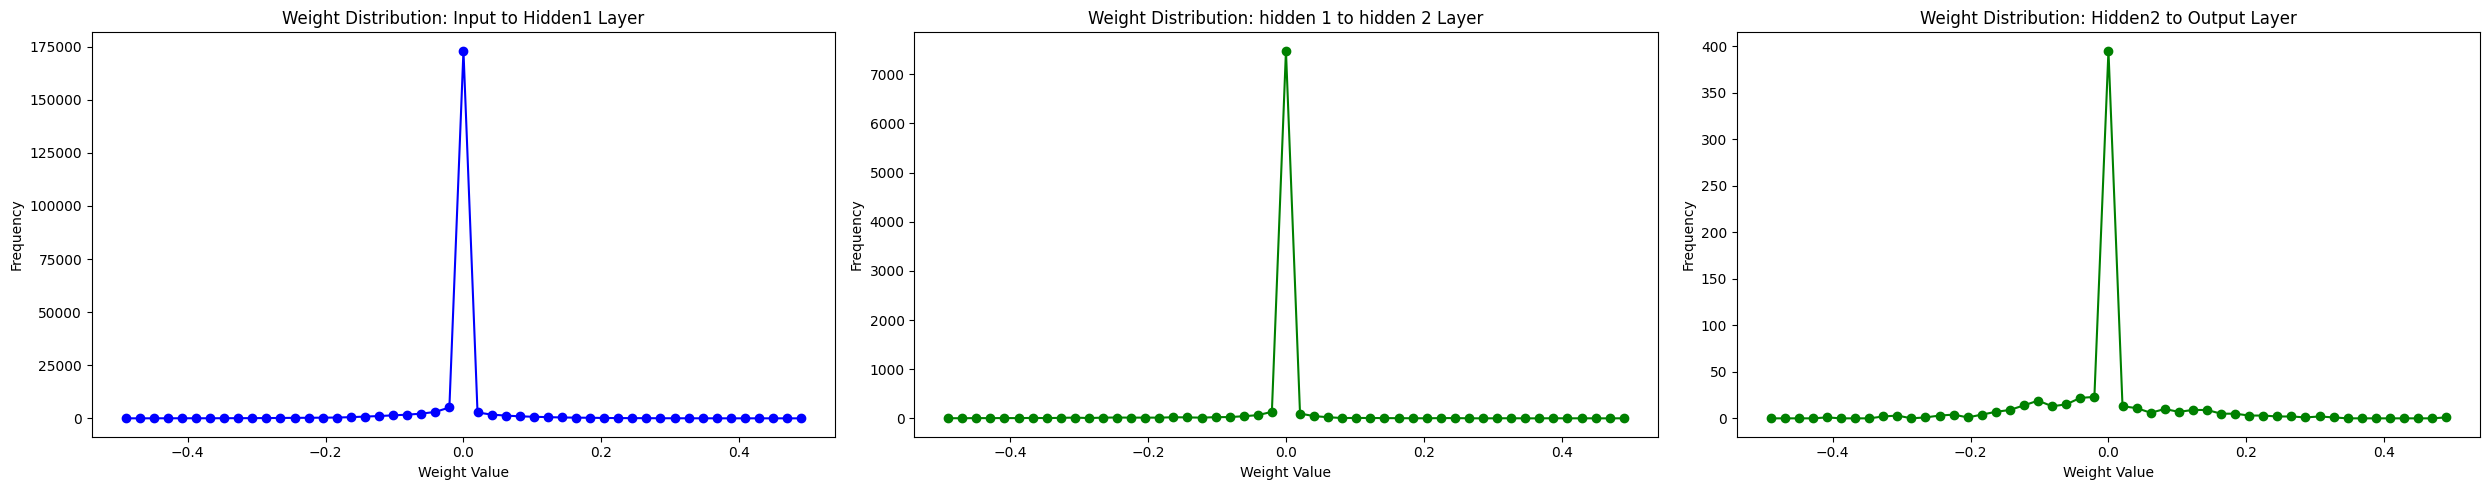

In [117]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [118]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 27811
Number of non-zero weights greater than 0.01 in layer 1: 715
Number of non-zero weights greater than 0.01 in layer 3: 246


In [119]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[2.0681642567140197, 4161.2443509282675, 791116557.644177, 48618236.843315154, 968983727176437.9, 2448132.440161029, 667.9928447457202, 2194401.7038208074, 82167.07292155133, 0.4215602106104194, 0.833263445004937, 1.0874340294802203e+19, 21.99017239587581, 0.3972713115249156, 0.42738907957072664, 0.71058178597591, 68.54039133997799, 0.19407822551531603, 0.4505957426929802, 2.582038276753825, 8004809478951766.0, 22918.4721197021, 25652352553.473152, 0.4071570625073074, 1.0319551362363397, 0.45964800077295975, 4.518882082195704, 648.722482128378, 0.40116565423484957, 0.2119108421880665, 0.38401395942931504, inf, 966559.2976862957, 2670434732685326.0, 0.3003154563925785, inf, 3.611982252388385, 1.3228054099355124, 1101122045005.1497, 0.40640045805106173, 243.94202412946083, 31161713.91644855, inf, 0.2259172947407815, inf, 1851667361526101.0, 17531092686894.184, 0.3537803926545357, 606810.7695129156, 2642242.1351349223, 0.3888684075532746, 1337397.7848190367, 207.10108316815302, 66.4784361

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62384/2415192822.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))


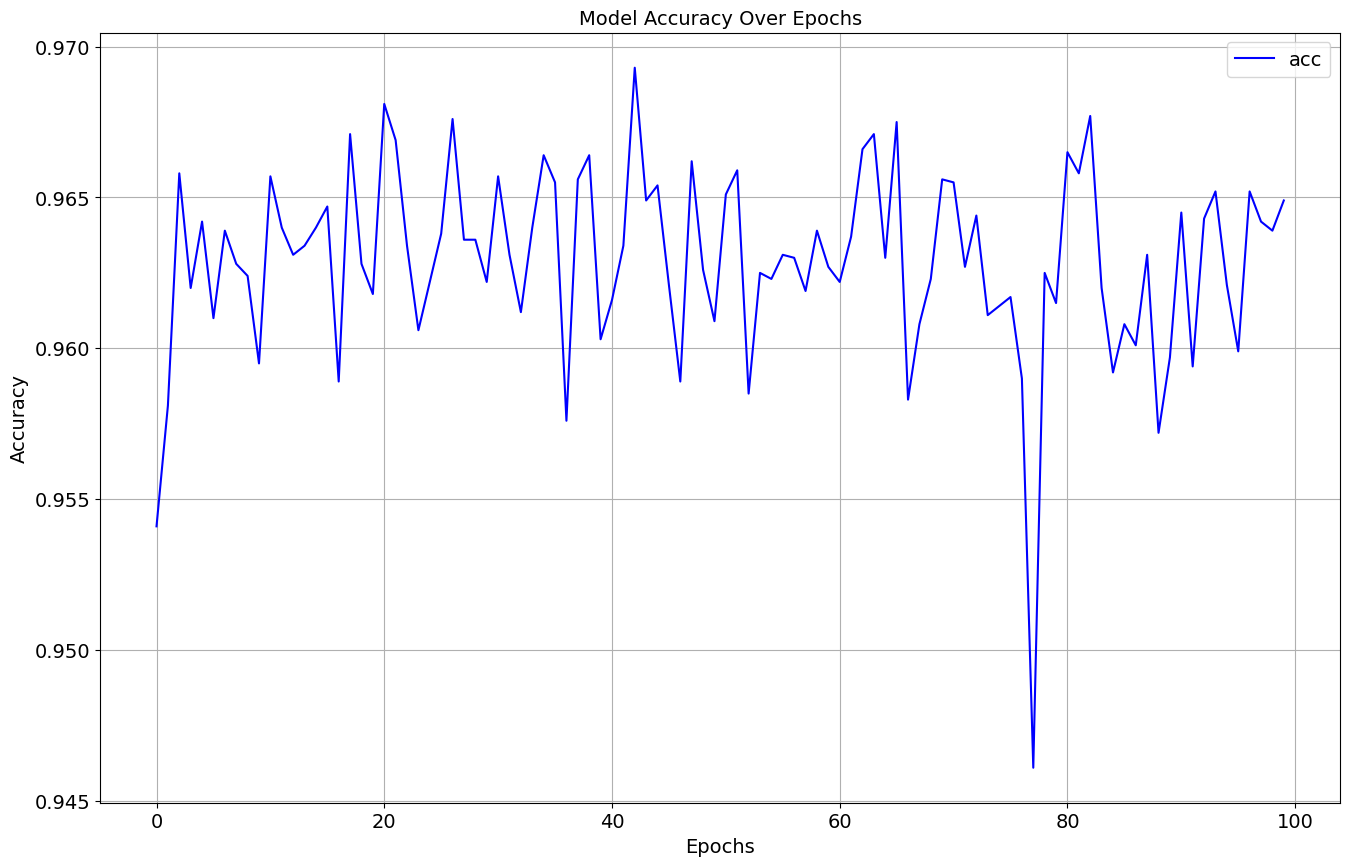

In [120]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [121]:
import pickle
with open('l2regularization0.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'l2regulatizationModel0.pt')